In [745]:
#1. Data Import + Basic Cleaning + Username/Date Prep

In [746]:
#a one off step, leaving in for reference
!pip install emoji

In [747]:
#step 1 - import the pandas library to work with the csv dataset, numpy for numerical operations, 
#regular expressions for pattern matching, emoji for emoji-related features and Standard Scaler for feature scaling
import pandas as pd
import numpy as np
import re
import emoji
from sklearn.preprocessing import StandardScaler

#step 2 - load the csv file with tweets
df = pd.read_csv("Tweets.csv")

#step 3 - show the first 5 rows to preview the data
print(df.head())

   id                                               link  \
0   0  https://twitter.com/HackneyPSC/status/17274436...   
1   1  https://twitter.com/cherrysattitude/status/172...   
2   2  https://twitter.com/diamoundgirls2/status/1710...   
3   3  https://twitter.com/mmtchi/status/172764634165...   
4   4  https://twitter.com/NoahIeeNG/status/172744319...   

                                                text              date  likes  \
0  A statement from psychoanalytic activists:  Th...  11/22/2023 21:47      0   
1                        bak bak bak bak doyamadınız  11/22/2023 15:27    443   
2  Check out 🏒 35 + different ERIK KARLSSON cards...    10/7/2023 7:15      0   
3  Il s'en passe des trucs pendant qu'on vous ori...  11/23/2023 11:12    381   
4  AW OKAY.. WELL THATS COOL, IM SURE PAL WILL AP...  11/22/2023 21:45      0   

   comments  
0         0  
1         9  
2         0  
3        44  
4         0  


In [748]:
#step 4 - extract usernames from the tweet link
#the username is always the fourth part after the third "/"
def extract_username(link):
    try:
        return link.split("/")[3] #this gets the username
    except:
        return None #if the link is missing or broken, this returns nothing

df['username'] = df['link'].apply(extract_username)

In [749]:
#step 5 - convert the 'date' column to datetime format needed for timeline features 
df['date'] = pd.to_datetime(df['date'], errors='coerce') #errors='coerce' deals with bad data

#step 6 - drop empty rows
df.dropna(how='all', inplace=True)

In [750]:
#step 7 - print basic info to see how many columns and rows are present
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15498 entries, 0 to 15497
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        15498 non-null  int64         
 1   link      15498 non-null  object        
 2   text      15470 non-null  object        
 3   date      15498 non-null  datetime64[ns]
 4   likes     15498 non-null  int64         
 5   comments  15498 non-null  int64         
 6   username  15498 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 847.7+ KB
None


In [751]:
#2. Feature Extraction

In [752]:
#step 1 - count how many tweets each user posted
tweet_count = df['username'].value_counts().rename_axis('username').reset_index(name='tweet_count')

In [753]:
#step 2 - sort tweets by user and date to calculate the gap between tweets
df_sorted = df.sort_values(by=['username', 'date'])
df_sorted['time_difference'] = df_sorted.groupby('username')['date'].diff().dt.total_seconds()

In [754]:
#step 3 - calculolate average time between tweets for each user in  minutes
average_time_between =  df_sorted.groupby('username')['time_difference'].mean().fillna(0)
average_time_between_minutes = (average_time_between / 60).rename('average_time_between_tweets_minutes')

In [755]:
#step 4 - check how many tweets are written in 50% >= all caps
def is_majority_all_caps(text):
    try:
        words = text. split()
        if not words:
            return False
        return sum(words.isupper() for word in words) / len(words) > 0.5
    except:
        return False

percentage_all_caps = df.groupby('username')['text'].apply(
    lambda tweets: np.mean([is_majority_all_caps(t) for t in tweets])
).rename('percentage_of_tweets_with_all_caps')

In [756]:
#step 5 - count average number of emojis in each tweet
def count_emojis(text):
    if not isinstance(text, str):
        return 0 
    return sum (1 for c in text if c in emoji.EMOJI_DATA)

average_emoji_count = df.groupby('username')['text'].apply(
    lambda tweets: np.mean([count_emojis(t) for t in tweets])
).rename('average_emoji_count_per_tweet')

In [757]:
#step 6 - track emotionally intense language using a lexicon
emotional_words = set()
target_emotions = {'anger', 'fear', 'disgust', 'sadness', 'negative'}

with open("NRC-Emotion-Lexicon-Wordlevel-v0.92.txt", "r", encoding="utf-8") as file:
    for line in file:
        parts = line.strip().split("\t")
        if len(parts) ==3:
            word, emotion, assoc = parts
            if assoc =='1' and emotion in target_emotions:
                emotional_words.add(word)

def count_emotional_words(text):
    if not isinstance(text, str):
        return 0
    words = re.findall(r'\b\w+\b', text.lower())
    return sum(word in emotional_words for word in words)

average_emotion_words = df.groupby('username')['text'].apply(
    lambda tweets: np.mean([count_emotional_words(t) for t in tweets])
).rename('average_emotionally_charged_words_per_tweet')

In [758]:
#step 7 - calculate tweet length average per user
average_tweet_length = df.groupby('username')['text'].apply(
    lambda tweets: np.mean([len(str(t)) for t in tweets])
).rename('average_tweet_length')

In [759]:
#step 8 - count average number of hashtags per tweet 
def count_hashtags(text):
    return len(re.findall(r'#\w+', str(text)))

average_hashtags = df.groupby('username')['text'].apply(
    lambda tweets: np.mean([count_hashtags(t) for t in tweets])
).rename('average_hashtag_frequency_per_tweet')

In [760]:
#step 9 - set tweet count index to match others
tweet_count = tweet_count.set_index('username')

In [761]:
#step 10 - combine all features coded until now into one dataset
feature_matrix = pd.concat([
    tweet_count,
    average_time_between_minutes,
    percentage_all_caps,
    average_emoji_count,
    average_emotion_words,
    average_tweet_length,
    average_hashtags
], axis=1)

In [762]:
#step 10a - adding tweet length cap as this distorted the plot with outliers being too far from the centroid
feature_matrix['average_tweet_length'] = feature_matrix['average_tweet_length'].clip(upper=1000)

In [763]:
#step 11 - chech the final result
print(feature_matrix.head())

                 tweet_count  average_time_between_tweets_minutes  \
username                                                            
Novytique                 84                            45.156627   
salusalemchalom           48                             5.851064   
Kuwait_KW01               38                           102.054054   
diamoundgirls2            37                            27.305556   
AvivaKlompas              31                           958.433333   

                 percentage_of_tweets_with_all_caps  \
username                                              
Novytique                                       0.0   
salusalemchalom                                 0.0   
Kuwait_KW01                                     0.0   
diamoundgirls2                                  0.0   
AvivaKlompas                                    0.0   

                 average_emoji_count_per_tweet  \
username                                         
Novytique                     

In [764]:
#3. Feature Scaling

In [765]:
#step 1 - use StandardScaler to normalise all values so they are similar in range
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_matrix)

In [766]:
#step 2 - convert back to dataframe so we can still see column names
scaled_df = pd.DataFrame(scaled_features, columns=feature_matrix.columns, index=feature_matrix.index)

In [767]:
#step 3 - check the final scaled values
print(scaled_df.head())

                 tweet_count  average_time_between_tweets_minutes  \
username                                                            
Novytique          46.443893                            -0.038475   
salusalemchalom    26.189500                            -0.040856   
Kuwait_KW01        20.563280                            -0.035029   
diamoundgirls2     20.000658                            -0.039557   
AvivaKlompas       16.624925                             0.016839   

                 percentage_of_tweets_with_all_caps  \
username                                              
Novytique                                       0.0   
salusalemchalom                                 0.0   
Kuwait_KW01                                     0.0   
diamoundgirls2                                  0.0   
AvivaKlompas                                    0.0   

                 average_emoji_count_per_tweet  \
username                                         
Novytique                     

In [768]:
#4. KMeans clustering

In [769]:
#step 1 - import kmeans and silhouette score from sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [770]:
#step 2 - decide how many clusters to try (as of now, we will try 2 to 10)
k_range = range(2, 11)
scores = []

In [771]:
#step 3 - loop through each k and calculate the silhouette score
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_df)
    score = silhouette_score(scaled_df, labels)
    scores.append(score)
    print(f"k = {k}, silhouette score = {score:.2f}")

k = 2, silhouette score = 0.67
k = 3, silhouette score = 0.73
k = 4, silhouette score = 0.30
k = 5, silhouette score = 0.30
k = 6, silhouette score = 0.30
k = 7, silhouette score = 0.33
k = 8, silhouette score = 0.34
k = 9, silhouette score = 0.32
k = 10, silhouette score = 0.32


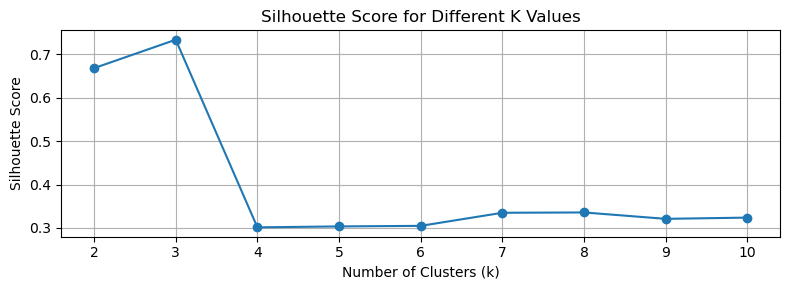

In [772]:
#step 4 - plot the silhouette scores to find the best k 
plt.figure(figsize=(8, 3))
plt.plot(k_range, scores, marker='o')
plt.title("Silhouette Score for Different K Values")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

In [833]:
#step 5 - choose the best k based on the plot
best_k = 3 #this has changed due to adjustments to lexicon
kmeans_final = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans_final.fit_predict(scaled_df)

In [835]:
#step 6 - add the cluster labels back to the feature matrix and df
feature_matrix['cluster'] = cluster_labels
df = df.merge(feature_matrix['cluster'], left_on='username', right_index=True, how='left')

In [837]:
#step 7 - check how many users are in each cluster
print(feature_matrix['cluster'].value_counts())

cluster
0    10329
1      237
2      115
Name: count, dtype: int64


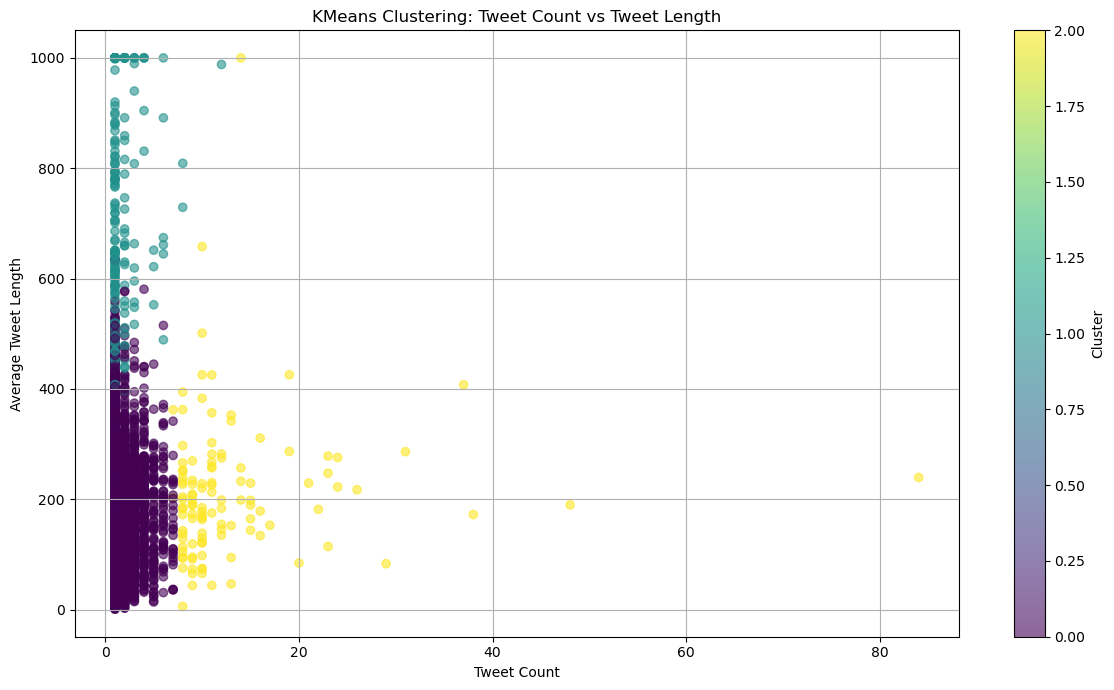

In [839]:
#step 8 - visualise the clusters in 2D using tweet count vs tweet lenght 
plt.figure(figsize=(12, 7))
plt.scatter(
    feature_matrix['tweet_count'],
    feature_matrix['average_tweet_length'],
    c=feature_matrix['cluster'],
    cmap='viridis',
    alpha=0.6
)
plt.xlabel("Tweet Count")
plt.ylabel("Average Tweet Length")
plt.title("KMeans Clustering: Tweet Count vs Tweet Length")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

In [777]:
#step 9 - create a new column to represent the week of each tweet
df['week'] = df['date'].dt.to_period('W').astype(str) #this formats each date tinto a weekly bracket

In [778]:
#step 10 - define helper functions for features
def is_majority_all_caps(text):
    try:
        words = text.split()
        if not words:
            return False
        return sum(word.isupper() for word in words) / len(words) > 0.5
    except:
        return False

def count_emojis(text):
    if not isinstance(text, str):
        return 0
    return sum(1 for c in text if c in emoji.EMOJI_DATA)

def count_emotional_words(text):
    if not isinstance(text, str):
        return 0
    words = re.findall(r'\b\w+\b', text.lower())
    return sum(word in emotional_words for word in words)

def count_hashtags(text):
    return len(re.findall(r'#\w+', str(text)))

In [779]:
#step 11 - calculate weekly feature values per user
weekly_metrics = df.groupby(['username', 'week']).agg(
    weekly_tweet_count=('text', 'count'),
    total_caps_tweets=('text', lambda tweets: sum(is_majority_all_caps(t) for t in tweets)),
    total_emojis=('text', lambda tweets: sum(count_emojis(t) for t in tweets)),
    total_emotional_words=('text', lambda tweets: sum(count_emotional_words(t) for t in tweets)),
    total_hashtags=('text', lambda tweets: sum(count_hashtags(t) for t in tweets)),
    average_tweet_length=('text', lambda tweets: np.mean([len(str(t)) for t in tweets])),
    average_time_between_tweets_minutes=('date', lambda dates: dates.sort_values().diff().dt.total_seconds().mean() / 60 if len(dates) > 1 else 0)
).reset_index()

In [780]:
#step 12 - preview the restult
print(weekly_metrics.head())

      username                   week  weekly_tweet_count  total_caps_tweets  \
0    001Flight  2023-12-11/2023-12-17                   1                  0   
1    0130Coach  2023-12-11/2023-12-17                   1                  0   
2       01IOTA  2023-12-11/2023-12-17                   1                  0   
3  021Scenario  2023-12-11/2023-12-17                   1                  0   
4        06Kiu  2023-11-20/2023-11-26                   1                  0   

   total_emojis  total_emotional_words  total_hashtags  average_tweet_length  \
0             0                      1               0                  63.0   
1             0                      8               0                 453.0   
2             0                      2               0                 280.0   
3             0                      0               0                  40.0   
4             0                      0               0                  73.0   

   average_time_between_tweets_minutes

In [781]:
#step 13 - calculate change in weekly behaviour for each user
#this step checks how did user's behaviour shift from one week to the next
weekly_metrics = weekly_metrics.sort_values(['username', 'week'])

#group by user and calculaate week-to-week difference for key features
diff_columns = ['weekly_tweet_count', 'total_caps_tweets', 'total_emojis', 'total_emotional_words', 'total_hashtags', 'average_tweet_length']
weekly_metrics_diff = weekly_metrics.groupby('username')[diff_columns].diff().abs()

#sum all differences per user to get a single score
weekly_metrics['behaviour_change_score'] = weekly_metrics_diff.sum(axis=1)

In [782]:
#step 14 - preview users with the biggest changes
most_spiky = weekly_metrics.sort_values('behaviour_change_score', ascending=False).head(10)
print(most_spiky[['username', 'week', 'behaviour_change_score'] + diff_columns])

            username                   week  behaviour_change_score  \
5550   SimyBenarroch  2023-12-11/2023-12-17                  3549.0   
8401           hhezi  2023-12-11/2023-12-17                  3493.0   
2297        GeopolPt  2023-12-11/2023-12-17                  2664.5   
10739   thehoffather  2023-12-11/2023-12-17                  2215.4   
7106        bdnews24  2023-12-11/2023-12-17                  1371.0   
7604       dani86873  2023-12-11/2023-12-17                  1322.5   
2281    GazaNewsPlus  2023-12-04/2023-12-10                  1221.0   
8830   julienbahloul  2023-12-11/2023-12-17                  1179.0   
7321          caitoz  2023-12-11/2023-12-17                  1138.0   
5128   RnaudBertrand  2023-12-04/2023-12-10                  1070.5   

       weekly_tweet_count  total_caps_tweets  total_emojis  \
5550                    1                  0             1   
8401                    1                  0             0   
2297                    2       

In [841]:
#step 15 - define clusters to match users with behavioural spikes
cluster_summary = feature_matrix.groupby('cluster').mean()
print(cluster_summary)

         tweet_count  average_time_between_tweets_minutes  \
cluster                                                     
0           1.316197                           445.628449   
1           1.603376                          2518.739238   
2          13.243478                         17978.982741   

         percentage_of_tweets_with_all_caps  average_emoji_count_per_tweet  \
cluster                                                                      
0                                       0.0                       0.241752   
1                                       0.0                       1.710619   
2                                       0.0                       0.360532   

         average_emotionally_charged_words_per_tweet  average_tweet_length  \
cluster                                                                      
0                                           1.256281            168.821964   
1                                           8.934564            731.9

In [843]:
#step 16 - users with the most spikes
most_spiky_clusters = df[df['username'].isin(most_spiky['username'])][['username', 'cluster']].drop_duplicates()
print(most_spiky_clusters)

           username  cluster
158        bdnews24        1
245   RnaudBertrand        1
678   julienbahloul        1
1318         caitoz        1
1884       GeopolPt        1
2778          hhezi        1
2902  SimyBenarroch        1
3464   thehoffather        1
4480   GazaNewsPlus        1
9717      dani86873        1


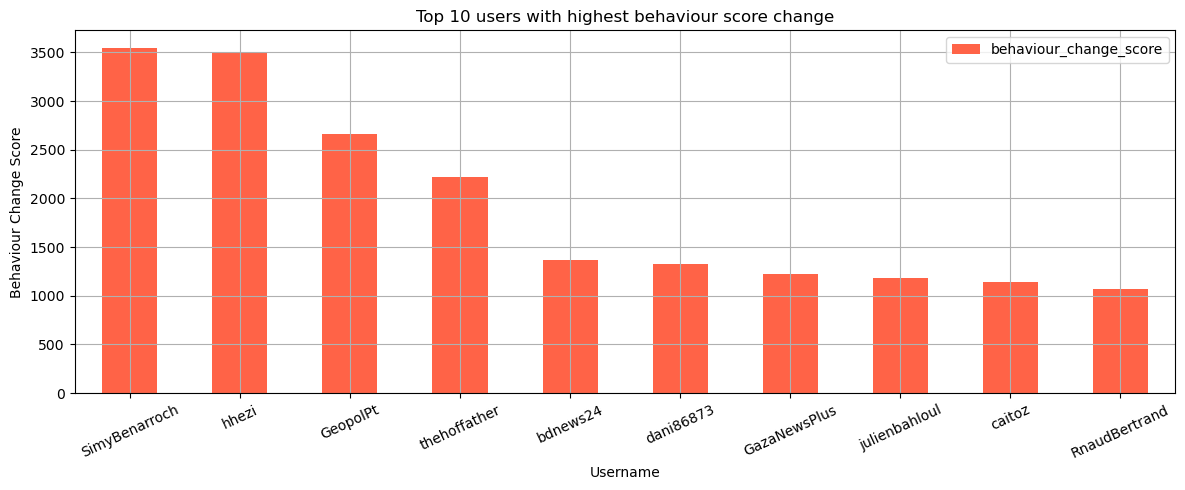

In [869]:
#step 17 - Bar Plot of behaviour score
most_spiky.plot(
    x='username',
    y='behaviour_change_score',
    kind='bar',
    figsize=(12, 5),
    color='tomato'
)

plt.title("Top 10 users with highest behaviour score change")
plt.ylabel("Behaviour Change Score")
plt.xlabel("Username")
plt.xticks(rotation=25)
plt.tight_layout()
plt.grid(True)
plt.show()